In [5]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import intake
import dask
import pandas as pd
dask.config.set({"array.slicing.split_large_chunks": True}) 

Open catalog with all Cycle 3 data

In [8]:
# cat = intake.open_catalog("../catalog.yaml")
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [14]:
print(list(cat))

['ICON', 'ICON_online', 'IFS', 'FESOM']


Print what is available for FESOM. This is list of experiments:

In [9]:
print(list(cat['FESOM']))

['IFS_4.4-FESOM_5-cycle3', 'IFS_28-FESOM_25-cycle3', 'IFS_9-FESOM_5-cycle3', 'FESOM_13_tropo_age_interpolated']


Next level is "data collections", basically sets of variables, that make sense to combine together 

In [10]:
print(list(cat['FESOM']['IFS_4.4-FESOM_5-cycle3']))

['2D_1h_0.25deg', '2D_1h_1deg', '2D_1h_native', '2D_daily_0.25deg', '2D_daily_1deg', '2D_daily_native', '2D_monthly_0.25deg', '2D_monthly_1deg', '2D_monthly_native', '3D_3h_native', '3D_3h_native_zarr', '3D_daily_native', '3D_daily_native_zarr', '3D_monthly_0.25deg', '3D_monthly_1deg', 'data_inventory', 'elem_grid', 'node_grid']


Have a look at what variables available in each of collections of the main experiment ('IFS_4.4-FESOM_5-cycle3'):

In [12]:
pd.set_option('max_colwidth', 2000)
cat['FESOM']['IFS_4.4-FESOM_5-cycle3']['data_inventory'].read()

,data source,Variables
0,2D_1h_1deg,"['a_ice', 'evap', 'fh', 'sss', 'sst']"
1,2D_1h_native,"['a_ice', 'evap', 'fh', 'node_area', 'sss', 'sst']"
2,2D_daily_0.25deg,"['MLD1', 'MLD2', 'atmice_x', 'atmice_y', 'atmoce_x', 'atmoce_y', 'fw', 'm_ice', 'm_snow', 'prec', 'ssh', 'uice', 'vice']"
3,2D_daily_1deg,"['MLD1', 'MLD2', 'atmice_x', 'atmice_y', 'atmoce_x', 'atmoce_y', 'fw', 'm_ice', 'm_snow', 'prec', 'ssh', 'uice', 'vice']"
4,2D_daily_native,"['MLD1', 'MLD2', 'atmice_x', 'atmice_y', 'atmoce_x', 'atmoce_y', 'fw', 'm_ice', 'm_snow', 'node_area', 'prec', 'ssh', 'uice', 'vice']"
5,2D_monthly_0.25deg,"['runoff', 'tx_sur', 'ty_sur']"
6,2D_monthly_1deg,"['runoff', 'tx_sur', 'ty_sur']"
7,2D_monthly_native,"['node_area', 'runoff', 'tx_sur', 'ty_sur']"
8,3D_3h_native,"['node_area', 'salt_upper', 'temp_upper', 'u_upper', 'v_upper', 'w_upper']"
9,3D_3h_native_zarr,"['salt_upper', 'temp_upper', 'u_upper', 'v_upper', 'w_upper']"


We create xarray dataset from [model][experiment][data collection]. In this case we will use `2D_daily_native` collection. Will take some time

In [13]:
# with dask.config.set(array_slicing_split_large_chunks=True):
data = cat["FESOM"]['IFS_4.4-FESOM_5-cycle3']['2D_daily_native'].to_dask()

This is FESOM data on native grid (7M grid points):

In [7]:
data

<xarray.Dataset>
Dimensions:   (time: 1808, nod2: 7402886)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20T23:56:00 ... 2024-12-31T23:56:00
Dimensions without coordinates: nod2
Data variables: (12/13)
    MLD1      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    MLD2      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmice_x  (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmice_y  (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmoce_x  (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmoce_y  (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    ...        ...
    m_ice     (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    m_snow    (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    prec      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    ssh       (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    uice      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    vice      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
Attributes: (12/17)
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       dfbf523
    FESOM_MeshPath:                      /work/bm1235/ifs-inputs_nxg_c3/fesom...
    FESOM_mesh_representative_checksum:  
    FESOM_ClimateDataPath:               /work/bm1235/ifs-inputs_nxg_c3/fesom...
    ...                                  ...
    FESOM_use_floatice:                  0
    FESOM_whichEVP:                      1
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      5
    FESOM_use_wsplit:                    -1
    FESOM_autorotate_back_to_geo:        -1

In [8]:
grid = run.node_grid.to_dask()
model_lon_fesom = grid.grid_center_lon.values
model_lat_fesom = grid.grid_center_lat.values
model_lon_fesom = np.where(model_lon_fesom>180, model_lon_fesom-360, model_lon_fesom)

In [9]:
lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

points_fesom = np.vstack((model_lon_fesom, model_lat_fesom)).T
data_sample = data['MLD2'][-1,:]

nn_interpolation = NearestNDInterpolator(points_fesom, data_sample.values)
interpolated_nn = nn_interpolation((lon2, lat2))

In [10]:
data_sample.values

array([-15.499698, -22.789177, -23.105612, ..., -33.094875, -31.181484,
       -33.892254], dtype=float32)

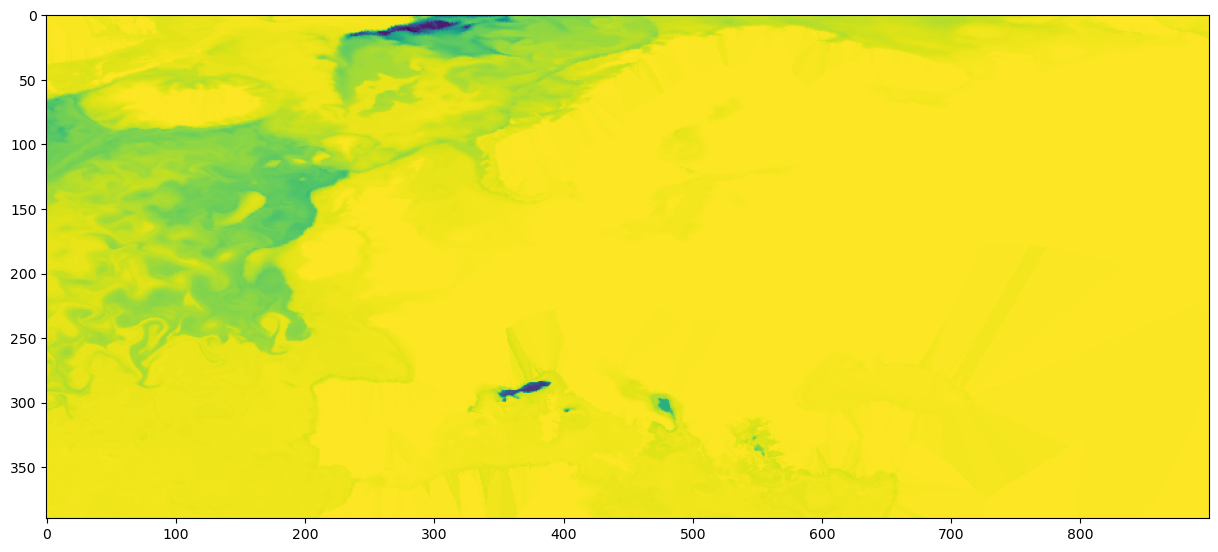

In [11]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## Masking land

In [12]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

In [13]:
def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(model_lon, model_lat)
    xt, yt, zt = lon_lat_to_cartesian(lons.flatten(), lats.flatten())

    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

In [14]:
from scipy.spatial import cKDTree

In [15]:
distances, inds = create_indexes_and_distances(model_lon_fesom, model_lat_fesom, lon2, lat2, k=1, workers=10)

In [16]:
radius_of_influence=5000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

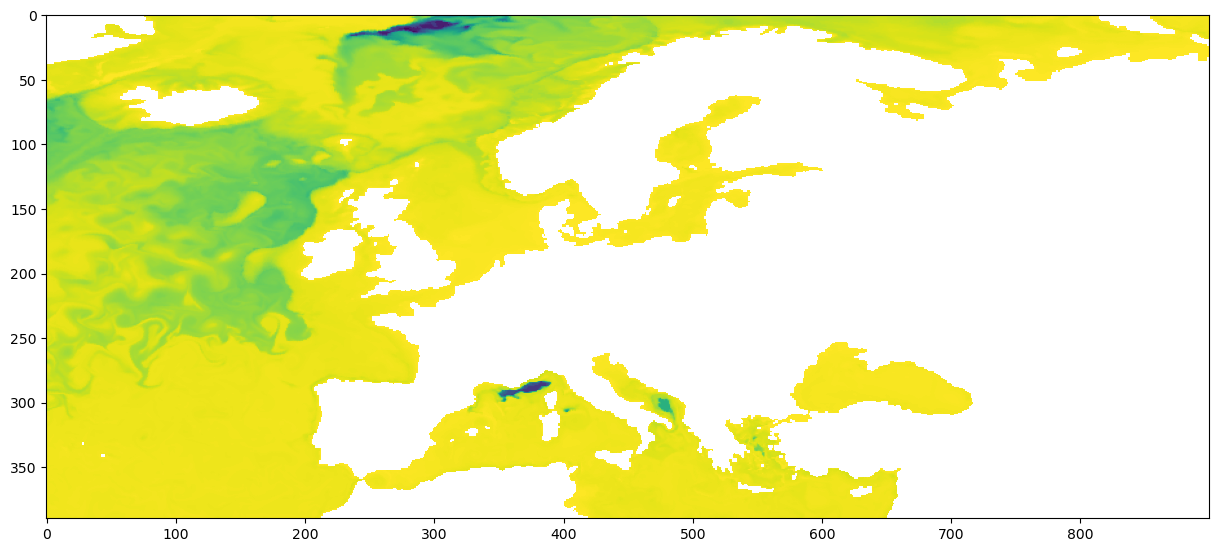

In [17]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(data_interpolated))